<a href="https://colab.research.google.com/github/guney1/LSTM_Stock_Prediction/blob/master/Copy_of_Optimized_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Get the required libaries

In [0]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [2]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib


--2019-06-04 13:32:03--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-06-04 13:32:03--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-06-04 13:32:03--  https://pilotfiber.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving pilotfiber

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from functools import partial
import talib
from sklearn.metrics import accuracy_score

In [4]:
tf.__version__

'1.13.1'

# Get the Data and Process it

In [0]:
start_date = '1970-12-31'
end_date = '2019-04-12'
df = web.DataReader('AAPL', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df_backtest = df.copy()
df_backtest["close_return"] = df_backtest["Close"].pct_change(1)
df_backtest["close_return_1df"] = df_backtest["close_return"].shift(-1)
df_backtest = df_backtest["'2017-09-06'":'2018-11-12']

In [0]:
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi_14"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)


In [0]:
df.head()

,High,Low,Open,Close,Volume,mid
Date,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.514509
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.487723
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.452009
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.463170
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.476562


In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)


# Train valid test split
train_df_ = df_.iloc[:9000]
test_df_ = df_.iloc[9000:9200]
train_df = df.iloc[:9000]
test_df = df.iloc[9000:9200]
out_of_sample = df.iloc[9200:9500]
out_of_sample_ = df_.iloc[9200:9500]


# Seperate features and target for training data
train_data_X = np.array(train_df_.values)
train_data_y = np.array(train_df["return_1df"].values)
# Seperate for valid data
test_data_X = np.array(test_df_.values)
test_data_y = np.array(test_df["return_1df"].values)
# Seperate for test data
X_out_sample = np.array(out_of_sample_.values)
y_out_sample = np.array(out_of_sample["return_1df"].values)




In [8]:
out_of_sample_.index

DatetimeIndex(['2017-09-06', '2017-09-07', '2017-09-08', '2017-09-11',
               '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15',
               '2017-09-18', '2017-09-19',
               ...
               '2018-10-30', '2018-10-31', '2018-11-01', '2018-11-02',
               '2018-11-05', '2018-11-06', '2018-11-07', '2018-11-08',
               '2018-11-09', '2018-11-12'],
              dtype='datetime64[ns]', name='Date', length=300, freq=None)

In [0]:

# Windowized normalization
smoothing_window_size = 600

scaler_min = MinMaxScaler()
for di in range(0,9000,smoothing_window_size):
    scaler_min.fit(train_data_X[di:di+smoothing_window_size,:])
    train_data_X[di:di+smoothing_window_size,:] = scaler_min.transform(train_data_X[di:di+smoothing_window_size,:])
    
test_data_X = scaler_min.transform(test_data_X)
X_out_sample = scaler_min.transform(X_out_sample)

In [10]:
df_.head()

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,WMA,adx,adxr,apo,aroondown,aroonup,aroonosc,bop,cmo,dx,mfi,minus_di,minus_dm,plus_di,plus_dm,ppo,rsi_14,slowk,slowd,macd,macdsignal,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-03-13,0.396643,0.394311,0.396103,0.394311,57825600.0,0.398438,-0.011080,0.410682,0.440999,0.460174,0.444931,24.366149,24.292801,-0.015176,85.714286,35.714286,-50.0,-0.768486,-38.334758,39.850975,70.514252,63.133826,0.113761,27.153462,0.048928,-2.013960,30.832621,7.984110,3.646682,-0.027250,-0.023074,-0.004175,-107.374569,-0.071928,-0.074905,0.443977,0.435036,-15.963820,18.357990,-92.386079
1981-03-16,0.410724,0.406846,0.407246,0.406846,9307200.0,0.415179,0.042017,0.407115,0.439027,0.457383,0.441510,24.620529,24.439035,-0.015187,78.571429,28.571429,-50.0,-0.103196,-27.866453,27.927461,75.130095,57.494163,0.105636,32.391406,0.059514,-3.028580,36.066774,35.782640,15.574229,-0.026896,-0.023839,-0.003057,-68.883935,-0.049253,-0.068928,0.441515,0.428143,-14.487484,26.632867,-78.632733
1981-03-17,0.430983,0.426572,0.426524,0.426572,10936800.0,0.435268,0.048387,0.406455,0.438715,0.454900,0.439584,23.790460,23.769120,-0.015450,71.428571,21.428571,-50.0,0.010866,-13.332343,12.999568,76.281720,50.368470,0.098090,38.779605,0.075521,-3.680785,43.333828,62.788922,35.518557,-0.024739,-0.024019,-0.000720,-20.640111,-0.035178,-0.045737,0.439756,0.423569,-9.683741,34.270546,-56.989946
1981-03-18,0.457766,0.453209,0.453061,0.453209,9234400.0,0.462054,0.061538,0.409288,0.438912,0.452689,0.439491,22.312524,22.403950,-0.015784,64.285714,14.285714,-50.0,0.032468,2.743726,3.099356,77.507199,42.958219,0.091084,45.706247,0.096910,-3.712090,51.371863,88.709737,62.427100,-0.020642,-0.023343,0.002701,39.513024,-0.026212,-0.013996,0.438445,0.422170,-2.995760,47.509333,-27.764649
1981-03-19,0.461069,0.458173,0.459711,0.458173,9452800.0,0.456473,-0.012077,0.412570,0.439279,0.450674,0.439786,21.068704,21.083676,-0.015853,57.142857,7.142857,-50.0,-0.531024,5.435875,4.899036,78.482728,41.308942,0.084578,45.564924,0.093292,-3.771619,52.717937,92.798245,81.432301,-0.016801,-0.022035,0.005234,52.741112,-0.005699,-0.005352,0.438160,0.421635,-1.154680,53.671034,-22.318107


In [11]:
df.head()

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,WMA,adx,adxr,apo,aroondown,aroonup,aroonosc,bop,cmo,dx,mfi,minus_di,minus_dm,plus_di,plus_dm,ppo,rsi_14,slowk,slowd,macd,macdsignal,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will,return_1df
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1981-03-13,0.396643,0.394311,0.396103,0.394311,57825600.0,0.398438,-0.011080,0.410682,0.440999,0.460174,0.444931,24.366149,24.292801,-0.015176,85.714286,35.714286,-50.0,-0.768486,-38.334758,39.850975,70.514252,63.133826,0.113761,27.153462,0.048928,-2.013960,30.832621,7.984110,3.646682,-0.027250,-0.023074,-0.004175,-107.374569,-0.071928,-0.074905,0.443977,0.435036,-15.963820,18.357990,-92.386079,0.042017
1981-03-16,0.410724,0.406846,0.407246,0.406846,9307200.0,0.415179,0.042017,0.407115,0.439027,0.457383,0.441510,24.620529,24.439035,-0.015187,78.571429,28.571429,-50.0,-0.103196,-27.866453,27.927461,75.130095,57.494163,0.105636,32.391406,0.059514,-3.028580,36.066774,35.782640,15.574229,-0.026896,-0.023839,-0.003057,-68.883935,-0.049253,-0.068928,0.441515,0.428143,-14.487484,26.632867,-78.632733,0.048387
1981-03-17,0.430983,0.426572,0.426524,0.426572,10936800.0,0.435268,0.048387,0.406455,0.438715,0.454900,0.439584,23.790460,23.769120,-0.015450,71.428571,21.428571,-50.0,0.010866,-13.332343,12.999568,76.281720,50.368470,0.098090,38.779605,0.075521,-3.680785,43.333828,62.788922,35.518557,-0.024739,-0.024019,-0.000720,-20.640111,-0.035178,-0.045737,0.439756,0.423569,-9.683741,34.270546,-56.989946,0.061538
1981-03-18,0.457766,0.453209,0.453061,0.453209,9234400.0,0.462054,0.061538,0.409288,0.438912,0.452689,0.439491,22.312524,22.403950,-0.015784,64.285714,14.285714,-50.0,0.032468,2.743726,3.099356,77.507199,42.958219,0.091084,45.706247,0.096910,-3.712090,51.371863,88.709737,62.427100,-0.020642,-0.023343,0.002701,39.513024,-0.026212,-0.013996,0.438445,0.422170,-2.995760,47.509333,-27.764649,-0.012077
1981-03-19,0.461069,0.458173,0.459711,0.458173,9452800.0,0.456473,-0.012077,0.412570,0.439279,0.450674,0.439786,21.068704,21.083676,-0.015853,57.142857,7.142857,-50.0,-0.531024,5.435875,4.899036,78.482728,41.308942,0.084578,45.564924,0.093292,-3.771619,52.717937,92.798245,81.432301,-0.016801,-0.022035,0.005234,52.741112,-0.005699,-0.005352,0.438160,0.421635,-1.154680,53.671034,-22.318107,0.012225


# Model Construction

In [0]:
X_train = train_data_X
y_train = train_data_y
X_test = test_data_X
y_test = test_data_y
X_out_sample = X_out_sample
y_out_sample = y_out_sample


In [13]:
n_steps = 20
n_inputs = X_train.shape[1]
num_nodes = 200
n_layers = 2
n_outputs = 1
# Reshape it for LSTM
X_test = X_test.reshape((-1, n_steps, n_inputs))
y_test = y_test.reshape((-1, n_steps, n_outputs))    
X_out_sample = X_out_sample.reshape((-1, n_steps, n_inputs))
y_out_sample = y_out_sample.reshape((-1, n_steps, n_outputs))
tf.reset_default_graph()
tf.set_random_seed(123)
np.random.seed(123)
# initializers
he_init = tf.contrib.layers.variance_scaling_initializer()
he_init1 = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_IN', uniform=True)
he_init2 = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', uniform=True)
he_init3 = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_AVG', uniform=False)
# Activations
tanh = tf.nn.tanh
elu = tf.nn.elu
leaky_relu = tf.nn.leaky_relu
# Construction
X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])
keep_prob = tf.placeholder_with_default(1.0, shape=())



cells = [tf.nn.rnn_cell.LSTMCell(num_units=num_nodes, use_peepholes=True, activation=tanh, initializer=he_init2) for layer in range(n_layers)]
cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob) for cell in cells]
multi_layer_cell = tf.nn.rnn_cell.MultiRNNCell(cells_drop)


rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)
stacked_rnn_outputs_ = tf.reshape(rnn_outputs, [-1, num_nodes])
stacked_outputs = tf.layers.dense(stacked_rnn_outputs_, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])


learning_rate = 0.005


loss = tf.reduce_mean(tf.square(outputs - y))

#Gradient clip for exploding gradient
threshold = 0.3
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs) # then apply it, normally minimize funtion do it all



init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_keep_prob = 0.7
max_checks_without_progress = 40
checks_without_progress = 0
best_loss = np.infty
n_iterations = 200
batch_size = 180
mse_train = []
mse_test = []
mse_out_ = []


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.


In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

# Model Execution

In [15]:
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            y_batch = y_batch.reshape((-1, n_steps, n_outputs))
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
        mse = loss.eval(feed_dict={X: X_batch, y: y_batch, keep_prob: train_keep_prob})
        mse_ = loss.eval(feed_dict={X: X_test, y: y_test, keep_prob: train_keep_prob})
        mse_out = loss.eval(feed_dict={X: X_out_sample, y: y_out_sample})
        mse_train.append(mse)
        mse_test.append(mse_)
        mse_out_.append(mse_out)
        print(iteration, "\tMSE:", mse, " MSE_TEST", mse_, " MSE_out", mse_out)
        if mse_ < best_loss: # adding stop loss
            save_path = saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
            best_loss = mse_
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break      


0 	MSE: 0.0037251953  MSE_TEST 0.0075039756  MSE_out 0.004914066
1 	MSE: 0.00055482757  MSE_TEST 0.0023870012  MSE_out 0.0010834584
2 	MSE: 0.0014914626  MSE_TEST 0.0016756094  MSE_out 0.0008355425
3 	MSE: 0.0008135217  MSE_TEST 0.00070980267  MSE_out 0.00060720183
4 	MSE: 0.0033696867  MSE_TEST 0.003322837  MSE_out 0.0009556203
5 	MSE: 0.0005511447  MSE_TEST 0.0002456715  MSE_out 0.00020823556
6 	MSE: 0.0007034177  MSE_TEST 0.00028976036  MSE_out 0.00026535348
7 	MSE: 0.0006990805  MSE_TEST 0.00014170597  MSE_out 0.00016912013
8 	MSE: 0.0006531393  MSE_TEST 0.00014545434  MSE_out 0.00020147167
9 	MSE: 0.00072107266  MSE_TEST 0.00012347213  MSE_out 0.00017684711
10 	MSE: 0.0005479511  MSE_TEST 0.00010277586  MSE_out 0.00015829485
11 	MSE: 0.0010131476  MSE_TEST 0.00034841924  MSE_out 0.00032493423
12 	MSE: 0.00055633555  MSE_TEST 0.00020910914  MSE_out 0.00027268866
13 	MSE: 0.00048269652  MSE_TEST 9.8099e-05  MSE_out 0.00013957551
14 	MSE: 0.00034249006  MSE_TEST 9.9169294e-05  MSE_ou

# Prediction

In [158]:
X_out_sample = X_out_sample.reshape((-1, n_steps, n_inputs))
y_out_sample = y_out_sample.reshape((-1, n_steps, n_outputs))
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    X_new = X_test
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    X_new_ = X_out_sample
    y_pred_out = sess.run(outputs, feed_dict={X: X_new_})

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final


# Results

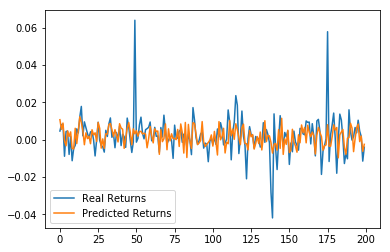

In [159]:
plt.plot(y_test.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred.reshape((-1, 1)), label = "Predicted Returns")
plt.legend()

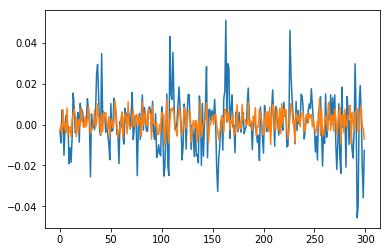

In [160]:
plt.plot(y_out_sample.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred_out.reshape((-1, 1)), label = "Predicted Returns")

In [161]:
comparison_change = pd.concat([pd.DataFrame(y_out_sample.reshape((-1, 1))), 
                        pd.DataFrame(y_pred_out.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change.columns = ["True", "Pred"]
# Tranform regression predictions to classification
test = []
for a in comparison_change["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)

# Classification Report
accuracy_score(test, pred)

0.6866666666666666

In [162]:
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.65      0.62      0.64       133
           1       0.71      0.74      0.72       167

    accuracy                           0.69       300
   macro avg       0.68      0.68      0.68       300
weighted avg       0.69      0.69      0.69       300



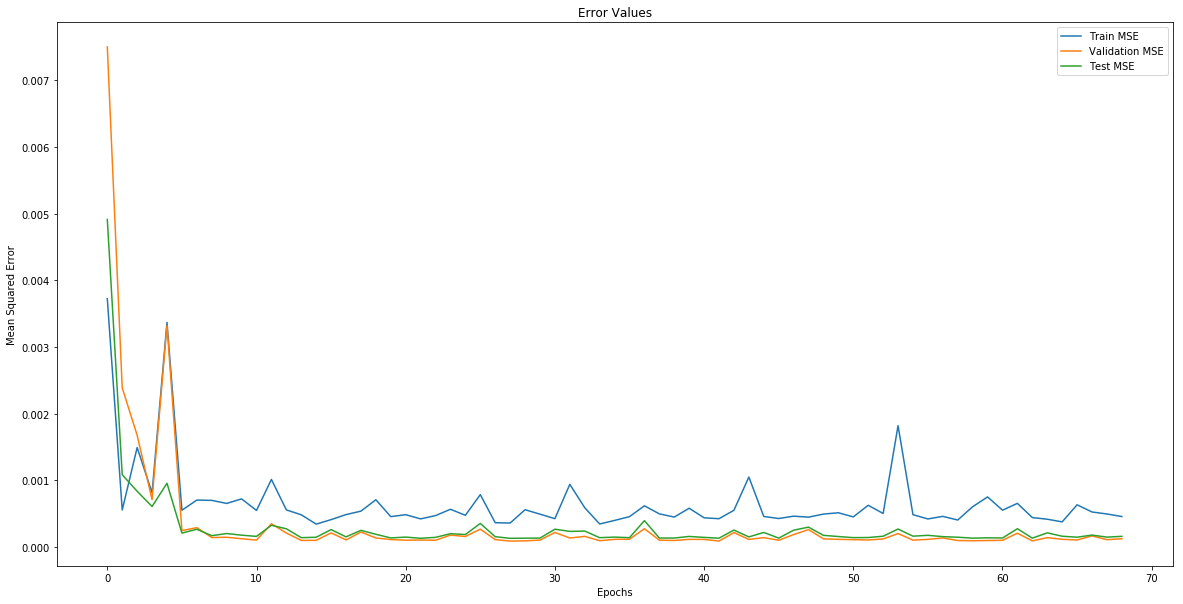

In [21]:
plt.figure(figsize=(20,10))
plt.title("Error Values")
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.plot(mse_train, label="Train MSE")
plt.plot(mse_test, label="Validation MSE")
plt.plot(mse_out_, label="Test MSE")
plt.legend()


# Backtest

In [0]:
df_backtest["signal"] = Suggestion
df_backtest["mid_return"] = df_backtest["mid"].pct_change(1)



In [0]:
df_backtest["pred_return"] = y_pred_out.reshape(-1, 1)
df_backtest["real_return"] = y_out_sample.reshape(-1, 1)


In [24]:
df_backtest.head()

,High,Low,Open,Close,Volume,mid,close_return,close_return_1df,pred_return,real_return
Date,,,,,,,,,,
2017-09-06,162.990005,160.520004,162.710007,161.910004,21651700.0,161.755005,-0.001049,-0.004015,-0.005348,-0.002813
2017-09-07,162.240005,160.360001,162.089996,161.259995,21928500.0,161.300003,-0.004015,-0.016309,-0.002214,-0.009051
2017-09-08,161.149994,158.529999,160.860001,158.630005,28611500.0,159.839996,-0.016309,0.018092,-0.006265,0.007070
2017-09-11,162.050003,159.889999,160.500000,161.500000,31580800.0,160.970001,0.018092,-0.003963,0.006855,0.002454
2017-09-12,163.960007,158.770004,162.610001,160.860001,71714000.0,161.365005,-0.003963,-0.007522,-0.001776,-0.015059


In [0]:
raw_prediction = y_pred_out.reshape(-1, 1)
Suggestion = []
percentChange = []


for d in range(len(raw_prediction)):
    percentChange.append(float((raw_prediction[d])))


    
for n in range(len(percentChange)):
    if (df["mid"][n]*(1+percentChange[n]))>df["Close"][n]:
        Suggestion.append(1) # buy if next day prediction higher
    elif (df["mid"][n]*(1+percentChange[n]))<df["Close"][n]:
        Suggestion.append(-1) # sell if next day prediction lower
    else:
        Suggestion.append(0) # hold otherwise

In [0]:
PurchaseHistory=[]
BuyPoints =  [[], []]
SellPoints = [[], []]
bought = False
for i in range(0, len(df)-1):
    if Suggestion[i] == 1 and not bought:
        PurchaseHistory.append(["Buy: ", df["Close"][i], i])
        BuyPoints[0].append(df["Close"][i])
        BuyPoints[1].append(i)
        bought = True
    if Suggestion[i] == -1 and bought:
        PurchaseHistory.append(["Sell:", df["Close"][i], i])
        SellPoints[0].append(df["Close"][i])
        SellPoints[1].append(i)        
        bought = False
if len(PurchaseHistory)%2 != 0:
    PurchaseHistory.pop()
    BuyPoints[0].pop()
    BuyPoints[1].pop() 

In [0]:
purch_hist = pd.DataFrame(np.array(PurchaseHistory))

In [0]:
purch_hist.columns = ["act", "price", "price_index"]

In [84]:
purch_hist


,act,price,price_index
0,Buy:,158.6300048828125,2
1,Sell:,159.64999389648438,5
2,Buy:,159.8800048828125,7
3,Sell:,158.6699981689453,8
4,Buy:,150.5500030517578,13
5,Sell:,153.27999877929688,16
6,Buy:,154.47999572753906,19
7,Sell:,153.47999572753906,20
8,Buy:,155.38999938964844,21
9,Sell:,159.75999450683594,30


In [0]:
backtest_values = np.array(df_backtest["Close"].iloc[purch_hist["price_index"].values[:]])
#plt.plot(np.array(Profit_cum).cumsum())

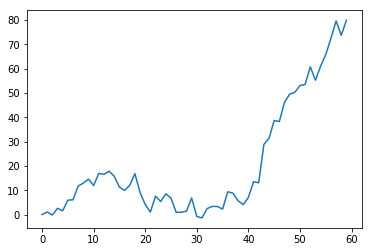

In [180]:
Profit_stock = [0]
for purchase in range(1, len(backtest_values)+1, 2):
    MoneyMade = (backtest_values[purchase] - backtest_values[purchase-1])
    Profit_stock.append(MoneyMade)
    
plt.plot(np.array(Profit_stock).cumsum())    

In [113]:
300/60

5.0

In [97]:
purch_hist["price_index"].values[:]

array(['2', '5', '7', '8', '13', '16', '19', '20', '21', '30', '32', '35',
       '36', '37', '40', '41', '43', '46', '48', '49', '50', '57', '62',
       '66', '67', '71', '72', '74', '75', '77', '78', '80', '81', '86',
       '87', '91', '92', '98', '99', '105', '106', '108', '113', '118',
       '119', '122', '123', '127', '128', '129', '131', '138', '139',
       '143', '145', '148', '149', '154', '155', '157', '158', '161',
       '162', '163', '167', '168', '174', '180', '181', '183', '184',
       '188', '191', '193', '195', '197', '198', '200', '201', '205',
       '207', '217', '218', '219', '220', '228', '232', '236', '237',
       '239', '240', '241', '242', '247', '248', '250', '252', '255',
       '256', '258', '259', '261', '262', '269', '270', '274', '276',
       '278', '279', '280', '282', '285', '286', '292', '293', '294',
       '295', '296'], dtype=object)

In [181]:
Profit = 0
for purchase in range(1, len(PurchaseHistory)+1, 2):
    MoneyMade = float(PurchaseHistory[purchase][1] - float(PurchaseHistory[purchase-1][1]))
    Profit += MoneyMade

print('$'+ str(round(Profit, 2)))

$54.38


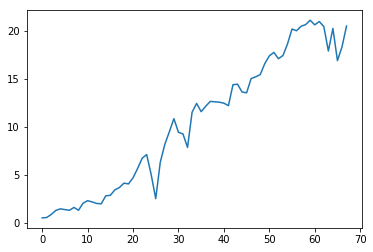

In [214]:
Profit_cum = []
for purchase in range(1, len(PurchaseHistory)+1, 2):
    MoneyMade = (PurchaseHistory[purchase][1] - PurchaseHistory[purchase-1][1])*100/PurchaseHistory[purchase-1][1]
    Profit_cum.append(MoneyMade)

plt.plot(np.array(Profit_cum).cumsum())
df_backtest["Close"].plot

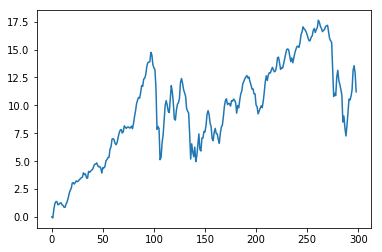

In [216]:
Profit_stock = []
for purchase in range(1, len(df)):
    MoneyMade = (df["Close"][purchase] - df["Close"][purchase-1])*100/df["Close"][purchase-1]
    Profit_stock.append(MoneyMade)

plt.plot(np.array(Profit_stock).cumsum())

In [0]:
cum_profit_df = pd.DataFrame(Profit_cum)

In [0]:
merged_port = pd.concat([df_backtest, cum_profit_df])

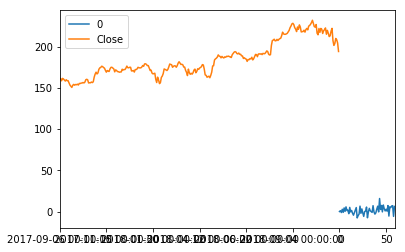

In [72]:
merged_port[[0, "Close"]].plot()

In [206]:
# Total ROI
MinimumRequiredCapital = max(BuyPoints[0])
ROI = Profit / MinimumRequiredCapital * 100
print("Return on Investment:", round(float(ROI), 2),"%")

Return on Investment: 18.65 %


In [0]:
y_out_sample = y_out_sample.reshape(-1, 1)
y_pred_out = y_pred_out.reshape(-1, 1)

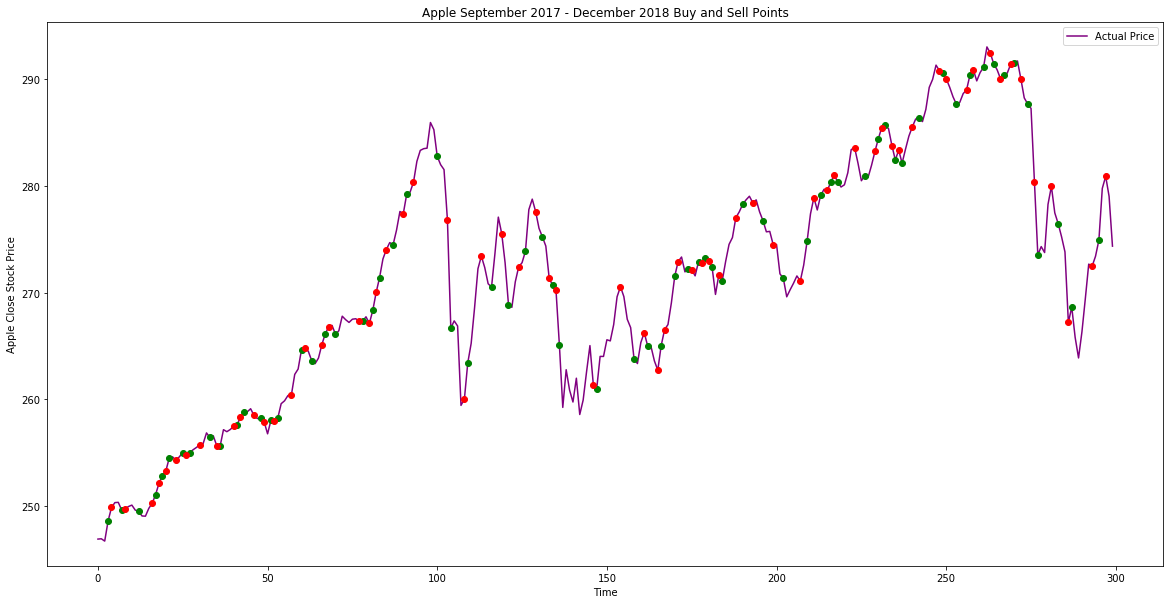

In [184]:
plt.figure(figsize=(20,10))
plt.plot(df["Close"].values, color =  'purple', label = "Actual Price")
#plt.plot(y_pred_out.reshape(-1, 1), color = 'blue', label = "Predicted Price")
plt.plot(BuyPoints[1], BuyPoints[0], "go")
plt.plot(SellPoints[1], SellPoints[0], "ro")

plt.title("Apple September 2017 - December 2018 Buy and Sell Points")
plt.xlabel('Time')
plt.ylabel('Apple Close Stock Price')
plt.legend()
plt.show()

In [207]:
# Benchmark, it is just buying and holding the stock
Benchmark = (df["Close"][-1] - df["Close"][0])/df["Close"][0] * 100
print("Benchmark:", round(float(Benchmark), 2),"%")

Benchmark: 11.13 %


# Test of the model on global data, Specifically I chosed to use small cap index, due to high volatility of the index we can test the generalization ability of the model better.

In [0]:

start_date = '1970-12-31'
end_date = '2019-04-12'
df = web.DataReader('SPY', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)
# Add tech indicators
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["return_1df"] = df["return_log"].shift(-1)



In [0]:
df = df.dropna()
# Create a copy of data set for denoising
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)
df.index
df = df['2017-09-06':'2018-11-12']
df_ = df_['2017-09-06':'2018-11-12']

scap_data_X = np.array(df_.values)
scap_data_y = np.array(df["return_1df"].values)

In [0]:
scap_data_y = scap_data_y.reshape(-1, n_steps, 1)
scap_data_X = scaler_min.transform(scap_data_X.reshape(-1, 40))

In [0]:
scap_data_X = scap_data_X.reshape(-1, n_steps, 40)

In [173]:
with tf.Session() as sess:
    saver.restore(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final")
    #saver.save(sess, "/content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_grad_trial_5")
    X_new = scap_data_X
    y_pred = sess.run(outputs, feed_dict={X: X_new})
    

INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/Colab Notebooks/my_LSTM_model_Final


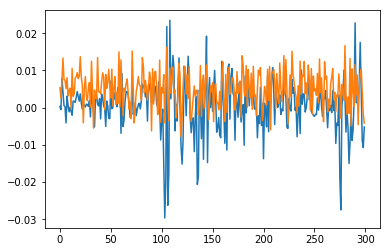

In [199]:
plt.plot(scap_data_y.reshape((-1, 1)), label = "Real Returns")
plt.plot(y_pred.reshape((-1, 1)), label = "Predicted Returns")

In [175]:
comparison_change_scap = pd.concat([pd.DataFrame(scap_data_y.reshape((-1, 1))), 
                        pd.DataFrame(y_pred.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change_scap.columns = ["True", "Pred"]
# Tranform regression predictions to classification
test = []
for a in comparison_change_scap["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change_scap["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)

# Classification Report
accuracy_score(test, pred)

0.66

In [198]:
# Scores on scap index, better than expected, probably it will perform better on SP ETF or large cap index
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.67      0.29      0.41       120
           1       0.66      0.91      0.76       180

    accuracy                           0.66       300
   macro avg       0.67      0.60      0.58       300
weighted avg       0.66      0.66      0.62       300



In [0]:
class MachineLearningForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = Suggestion
        return signals

In [0]:
from abc import ABCMeta, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

class Strategy(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        raise NotImplementedError("Should implement generate_signals()!")
        
class Portfolio(object):

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        raise NotImplementedError("Should implement backtest_portfolio()!")

        
class RandomForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = np.sign(np.random.randn(len(signals)))
        return signals
    
class MarketIntradayPortfolio(Portfolio):
    
    def __init__(self, symbol, bars, signals, initial_capital=100000.0, trading_sum = 100):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.trading_sum = float(trading_sum)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        positions[self.symbol] = self.trading_sum*self.signals['signal']
        return positions
                    
    def backtest_portfolio(self):
        portfolio = pd.DataFrame(index=self.positions.index)
        pos_diff = self.positions.diff()
        
        
        for n in range(1, len(df)-1):
          portfolio['price_diff'][n] = self.bars['Close'][n]-self.bars['Close'][n-1]
        
        portfolio['profit'] = self.positions[self.symbol] * portfolio['price_diff']

        portfolio['total'] = self.initial_capital + portfolio['profit'].cumsum()
        portfolio['returns'] = portfolio['total'].pct_change()
        return portfolio

In [195]:
STEP = 1
FORECAST = 1
INIT_CAPITAL = 10000
STAKE = 10
rfs = MachineLearningForecastingStrategy('LTC', df, pred)
signals = rfs.generate_signals()
portfolio = MarketIntradayPortfolio('LTC', df, signals, INIT_CAPITAL, STAKE)
returns = portfolio.backtest_portfolio()


KeyError: ignored

In [0]:
returns['signal'] = signals
our_pct_growth = Profit_cum
benchmark_ptc_growth = df['Close'].pct_change().cumsum()

In [197]:
plt.figure()
plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
plt.legend()
plt.show()

ValueError: ignored

<Figure size 432x288 with 1 Axes>